# Cell Data Analysis


In [ ]:
# Import libraries
import sys
sys.path.insert(0, '/myhome/iris')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# Import modular pipeline components
from src.data_pipeline.data_sources import H5DataSource
from src.data_pipeline.data_filters import (
    PlaneCountFilter,
    EmptySegmentationFilter,
    MultipleObjectsFilter,
    CellNucleiOverlappingFilter,
)
from src.data_pipeline.data_sources import FilteredDataSource
from src.data_pipeline.data_transforms import (
    SelectPlanesTransform,
    NormalizeTransform,
    TransformPipeline,
    CropTransform,
)
from src.data_pipeline.dataset import ModularCellDataset, compute_fucci_labels

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful! ")

✓ All imports successful!


## 1. Load Raw Data and Inspect Structure

First, let's load the data source and examine the raw data structure.

In [5]:
# Create data source
h5_path = "/mydata/iris/shared/fucci_3t3_221124_filtered_noNG030JP208_with_nuclei_seg.h5"

print("Loading H5 data source...")
data_source = H5DataSource(
    path=h5_path,
    channel_keys=["405", "488", "561", "bf"],
    seg_key="seg",
    nuclei_seg_key="nuclei_seg",
    plane_selection="all",
)
filtered_data_source = FilteredDataSource(
    data_source,
    filters=[
        PlaneCountFilter(),
        EmptySegmentationFilter(),
        MultipleObjectsFilter(),
        CellNucleiOverlappingFilter(max_ratio=0.2),
    ],
    force_refilter=False,
)
n_sample = min(2000, len(filtered_data_source.get_cell_ids()))
sample_ids = np.random.choice(filtered_data_source.get_cell_ids(), n_sample, replace=False)
# dataset = ModularCellDataset(data_source, debug=True)
# _  = dataset[12]


Loading H5 data source...
✓ Loaded filter results from cache: /mydata/iris/shared/fucci_3t3_221124_filtered_noNG030JP208_with_nuclei_seg_filtered_adf7839c.json

FILTERING STATISTICS
Total cells:                22,677
Valid cells:                17,989
Invalid cells:              4,688

Rejection reasons:
  - nuclei_too_large              : 2,540
  - multiple_cells                : 966
  - failed_segmentation_nuclei_segmentation: 916
  - invalid_plane_count           : 177
  - failed_segmentation_segmentation: 89

Retention rate:             79.3%


## 2. Analyze Channel Statistics

Analyze the intensity statistics for each channel in the filtered dataset.

Analyzing channel statistics from data...



Computing channel stats: 100%|██████████| 2000/2000 [00:16<00:00, 120.05it/s]


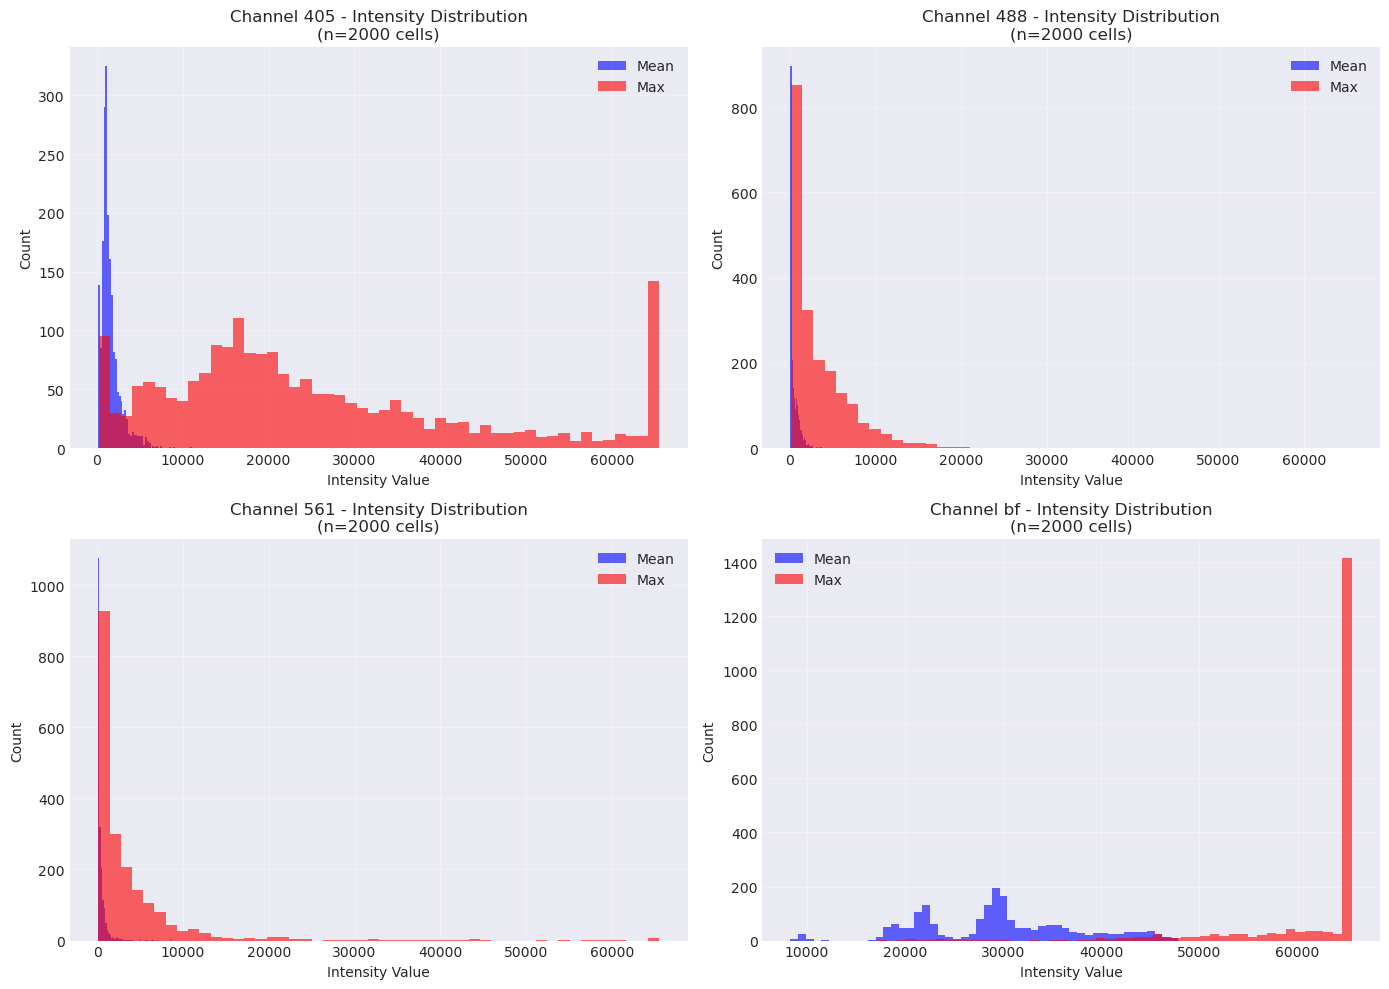


CHANNEL STATISTICS SUMMARY

405:
  Mean intensity: 1535.74 ± 1169.31
  Max intensity:  25191.59 ± 17895.16
  Dynamic range:  [44, 65535]

488:
  Mean intensity: 553.33 ± 589.73
  Max intensity:  3468.47 ± 4324.97
  Dynamic range:  [45, 65535]

561:
  Mean intensity: 455.78 ± 639.87
  Max intensity:  4108.53 ± 7609.15
  Dynamic range:  [45, 65535]

bf:
  Mean intensity: 29697.81 ± 7921.51
  Max intensity:  61770.32 ± 7964.11
  Dynamic range:  [1021, 65535]

✓ Channel analysis complete!


In [22]:
# Sample cells for channel analysis
print("Analyzing channel statistics from data...\n")

channel_stats = {ch: {'mean': [], 'std': [], 'min': [], 'max': []} 
                for ch in ['405', '488', '561', 'bf']}

for cell_id in tqdm(sample_ids, desc="Computing channel stats"):
    cell_data = data_source.load_cell(cell_id)
    
    for ch in ['405', '488', '561', 'bf']:
        if ch in cell_data.channels:
            planes = cell_data.channels[ch]
            # Compute stats across all planes
            all_pixels = np.concatenate([plane.flatten() for plane in planes])
            
            channel_stats[ch]['mean'].append(all_pixels.mean())
            channel_stats[ch]['std'].append(all_pixels.std())
            channel_stats[ch]['min'].append(all_pixels.min())
            channel_stats[ch]['max'].append(all_pixels.max())

# Visualize channel statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ch in enumerate(['405', '488', '561', 'bf']):
    ax = axes[idx]
    
    # Plot distributions
    ax.hist(channel_stats[ch]['mean'], bins=50, alpha=0.6, label='Mean', color='blue')
    ax.hist(channel_stats[ch]['max'], bins=50, alpha=0.6, label='Max', color='red')
    
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Channel {ch} - Intensity Distribution\n(n={n_sample} cells)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("CHANNEL STATISTICS SUMMARY")
print(f"{'='*60}")
for ch in ['405', '488', '561', 'bf']:
    print(f"\n{ch}:")
    print(f"  Mean intensity: {np.mean(channel_stats[ch]['mean']):.2f} ± {np.std(channel_stats[ch]['mean']):.2f}")
    print(f"  Max intensity:  {np.mean(channel_stats[ch]['max']):.2f} ± {np.std(channel_stats[ch]['max']):.2f}")
    print(f"  Dynamic range:  [{np.min(channel_stats[ch]['min']):.0f}, {np.max(channel_stats[ch]['max']):.0f}]")

print(f"\n✓ Channel analysis complete!")

## 3. Analyze FUCCI Labels (488 and 561)

Analyze the distribution of FUCCI fluorescent markers that indicate cell cycle phase.

Extracting FUCCI labels...



Computing FUCCI labels: 100%|██████████| 2000/2000 [01:40<00:00, 19.90it/s] 



FUCCI LABEL STATISTICS

Nuclei-based FUCCI intensities:
       488_intensity  561_intensity  norm_intensity
count    2000.000000    2000.000000     2000.000000
mean        6.584774       5.976125        9.055108
std         1.495512       2.101867        1.931648
min         1.738468      -6.272138        2.123240
25%         5.589305       4.213985        8.141923
50%         6.697221       6.497582        9.181215
75%         7.816216       7.606391       10.384249
max        10.527111      10.351209       14.763725

Cell-based FUCCI intensities:
       488_intensity  561_intensity  norm_intensity
count    2000.000000    2000.000000     2000.000000
mean        6.318019       5.720185        8.684554
std         1.497789       1.998336        1.857883
min         1.953937      -7.304067        2.356746
25%         5.214324       4.072587        7.798402
50%         6.374866       6.192270        8.826035
75%         7.599692       7.295305        9.954337
max         9.498685       9

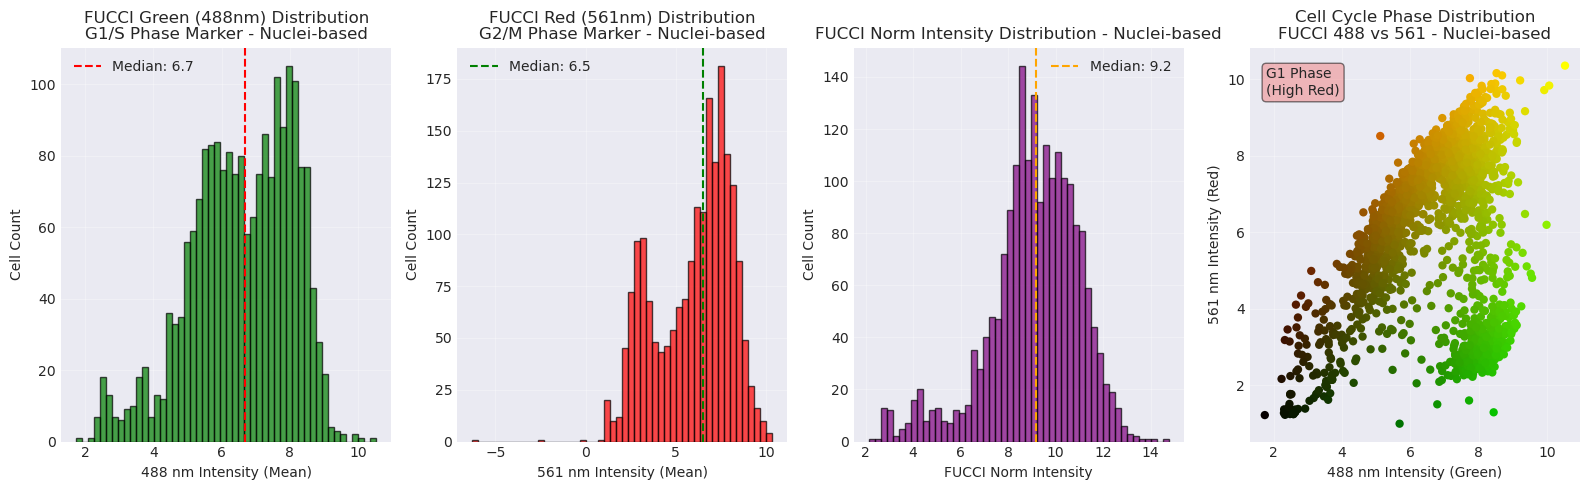

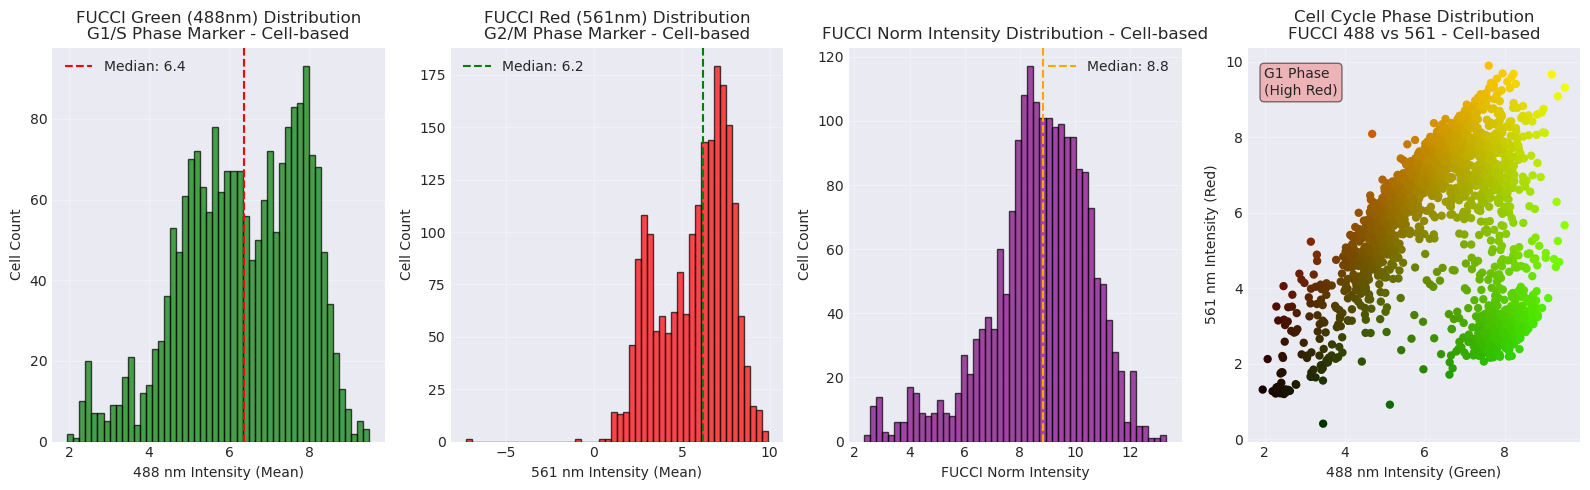


Correlation between 488 and 561 for Nuclei: 0.225
Correlation between 488 and 561 for Cells: 0.192
Correlation between Nuclei and Cell based FUCCI intensities:
  488 nm Intensity Correlation: 0.994
  561 nm Intensity Correlation: 0.994


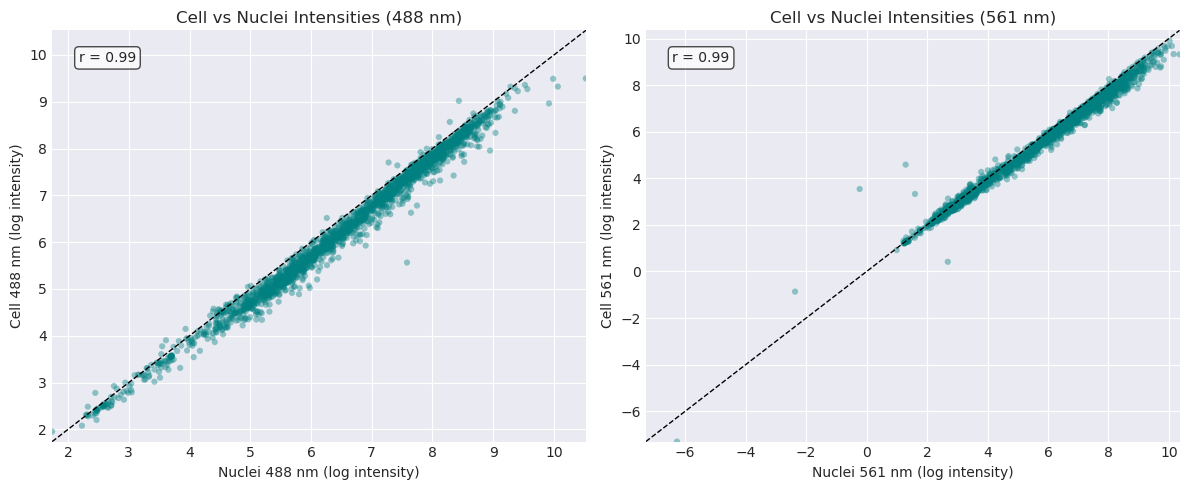


✓ FUCCI analysis complete!


In [21]:
from matplotlib.colors import Normalize
from src.data_pipeline.dataset import show_images

# Extract FUCCI labels (488 and 561 intensities)
print("Extracting FUCCI labels...\n")

fucci_488_nuclei = []
fucci_561_nuclei = []
fucci_488_cell = []
fucci_561_cell = []

for cell_id in tqdm(sample_ids, desc="Computing FUCCI labels"):
    cell_data = data_source.load_cell(cell_id)
    try:
        fucci_labels_nuclei = compute_fucci_labels(cell_data, "nuclei_segmentation")
        fucci_labels_cell = compute_fucci_labels(cell_data, "segmentation")
    except:
        show_images(cell_data.channels["405"], [None]*3)
        show_images(cell_data.channels["bf"], [None]*3)
        import pdb; pdb.set_trace()
    fucci_488_cell.append(fucci_labels_cell[0])
    fucci_561_cell.append(fucci_labels_cell[1])
    fucci_488_nuclei.append(fucci_labels_nuclei[0])
    fucci_561_nuclei.append(fucci_labels_nuclei[1])


# Convert to DataFrame
df_fucci_nuclei = pd.DataFrame({
    '488_intensity': fucci_488_nuclei,
    '561_intensity': fucci_561_nuclei,
    'norm_intensity': np.sqrt(np.pow(fucci_488_nuclei, 2) + np.pow(fucci_561_nuclei, 2))
})
df_fucci_cell = pd.DataFrame({
    '488_intensity': fucci_488_cell,
    '561_intensity': fucci_561_cell,
    'norm_intensity': np.sqrt(np.pow(fucci_488_cell, 2) + np.pow(fucci_561_cell, 2))
})

print(f"\n{'='*60}")
print("FUCCI LABEL STATISTICS")
print(f"{'='*60}")
print("\nNuclei-based FUCCI intensities:")
print(df_fucci_nuclei.describe())
print("\nCell-based FUCCI intensities:")
print(df_fucci_cell.describe())

# Visualize FUCCI distribution

for i, (df_fucci, title) in enumerate(zip([df_fucci_nuclei, df_fucci_cell], ['Nuclei-based', 'Cell-based'])):
    fig = plt.figure(figsize=(16, 5))
    ax1 = plt.subplot(1, 4, 1)
    ax1.hist(df_fucci['488_intensity'], bins=50, color='green', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('488 nm Intensity (Mean)')
    ax1.set_ylabel('Cell Count')
    ax1.set_title(f'FUCCI Green (488nm) Distribution\nG1/S Phase Marker - {title}')
    ax1.axvline(df_fucci['488_intensity'].median(), color='red', linestyle='--',
            label=f'Median: {df_fucci["488_intensity"].median():.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 561 distribution
    ax2 = plt.subplot(1, 4, 2)
    ax2.hist(df_fucci['561_intensity'], bins=50, color='red', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('561 nm Intensity (Mean)')
    ax2.set_ylabel('Cell Count')
    ax2.set_title(f'FUCCI Red (561nm) Distribution\nG2/M Phase Marker - {title}')
    ax2.axvline(df_fucci['561_intensity'].median(), color='green', linestyle='--',
            label=f'Median: {df_fucci["561_intensity"].median():.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # FUCCI norm
    ax3 = plt.subplot(1, 4, 3)
    ax3.hist(df_fucci['norm_intensity'], bins=50, color='purple', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('FUCCI Norm Intensity')
    ax3.set_ylabel('Cell Count')
    ax3.set_title(f'FUCCI Norm Intensity Distribution - {title}')
    ax3.axvline(df_fucci['norm_intensity'].median(), color='orange', linestyle='--',
            label=f'Median: {df_fucci["norm_intensity"].median():.1f}')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 2D scatter plot (cell cycle phases)
    df_fucci = df_fucci[(df_fucci["488_intensity"] > 0) & (df_fucci["561_intensity"] > 0)]
    ax4 = plt.subplot(1, 4, 4)
    scatter = ax4.scatter(df_fucci['488_intensity'], df_fucci['561_intensity'])
    ax4.set_xlabel('488 nm Intensity (Green)')
    ax4.set_ylabel('561 nm Intensity (Red)')
    ax4.set_title(f'Cell Cycle Phase Distribution\nFUCCI 488 vs 561 - {title}')
    ax4.grid(alpha=0.3)

    # Add phase annotations
    ax4.text(0.05, 0.95, 'G1 Phase\n(High Red)', transform=ax4.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    color_components = df_fucci[['488_intensity', '561_intensity']].to_numpy()
    row_min = color_components.min(axis=1, keepdims=True)
    row_max = color_components.max(axis=1, keepdims=True)
    denom = np.maximum(row_max - row_min, 1e-9)
    normalized = (color_components - row_min) / denom
    color_map = np.column_stack([normalized[:, 1], normalized[:, 0], np.zeros(len(df_fucci))])
    scatter.set_facecolor(color_map)
    scatter.set_edgecolor('none')
    green_norm = Normalize(vmin=df_fucci['488_intensity'].min(), vmax=df_fucci['488_intensity'].max())
    red_norm = Normalize(vmin=df_fucci['561_intensity'].min(), vmax=df_fucci['561_intensity'].max())
    color_map = np.stack([
        red_norm(df_fucci['561_intensity']),
        green_norm(df_fucci['488_intensity']),
        np.zeros(len(df_fucci))
    ], axis=1)
    scatter.set_facecolor(color_map)
    scatter.set_edgecolor('none')
    plt.tight_layout()
    plt.show()

# Correlation analysis
correlation_nuclei = df_fucci_nuclei['488_intensity'].corr(df_fucci_nuclei['561_intensity'])
print(f"\nCorrelation between 488 and 561 for Nuclei: {correlation_nuclei:.3f}")

correlation_cell = df_fucci_cell['488_intensity'].corr(df_fucci_cell['561_intensity'])
print(f"Correlation between 488 and 561 for Cells: {correlation_cell:.3f}")

print("Correlation between Nuclei and Cell based FUCCI intensities:")
correlation_488 = df_fucci_nuclei['488_intensity'].corr(df_fucci_cell['488_intensity'])
print(f"  488 nm Intensity Correlation: {correlation_488:.3f}")
correlation_561 = df_fucci_nuclei['561_intensity'].corr(df_fucci_cell['561_intensity'])
print(f"  561 nm Intensity Correlation: {correlation_561:.3f}")

fig_fucci_compare, axes_fucci_compare = plt.subplots(1, 2, figsize=(12, 5))

channel_info = [
    ('488_intensity', '488 nm', correlation_488),
    ('561_intensity', '561 nm', correlation_561),
]

for ax, (column, label, corr_val) in zip(axes_fucci_compare, channel_info):
    valid_mask = ~df_fucci_nuclei[column].isna() & ~df_fucci_cell[column].isna() 
    nuclei_vals = df_fucci_nuclei.loc[valid_mask, column]
    cell_vals = df_fucci_cell.loc[valid_mask, column]

    ax.scatter(nuclei_vals, cell_vals, alpha=0.4, s=20, color='teal', edgecolors='none')
    axis_min = min(nuclei_vals.min(), cell_vals.min())
    axis_max = max(nuclei_vals.max(), cell_vals.max())
    ax.plot([axis_min, axis_max], [axis_min, axis_max], linestyle='--', color='black', linewidth=1)

    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)
    ax.set_xlabel(f'Nuclei {label} (log intensity)')
    ax.set_ylabel(f'Cell {label} (log intensity)')
    ax.set_title(f'Cell vs Nuclei Intensities ({label})')

    if corr_val is not None and not np.isnan(corr_val):
        ax.text(
            0.05,
            0.95,
            f'r = {corr_val:.2f}',
            transform=ax.transAxes,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
        )

plt.tight_layout()
plt.show()

print(f"\n✓ FUCCI analysis complete!")

## 4. Test Transform Pipeline

Create and test the preprocessing transform pipeline.

In [ ]:
transform_pipeline = TransformPipeline([
    SelectPlanesTransform(plane_selection='all'),
    NormalizeTransform(method='standardize', channel_keys=['405', 'bf']),
    CropTransform(padding=20),
])
dataset = ModularCellDataset(filtered_data_source, transform=transform_pipeline, debug=False)
print("Transform pipeline steps:")
config = transform_pipeline.get_config()
for i, t in enumerate(config['transforms'], 1):
    print(f"  {i}. {t['type']}")

# Test on sample cells
print(f"\nTesting transform pipeline on sample cells...\n")

test_ids = sample_ids[:2]
channels = ['bf', '405', '488', '561']
for i, cell_id in enumerate(test_ids):
    cell_data = data_source.load_cell(cell_id)
    cell_idx = filtered_data_source.get_cell_ids().index(cell_id)
    transformed = transform_pipeline(cell_data)
    data_set_images = dataset[cell_idx][0]

    fig, axes = plt.subplots(3, 6, figsize=(18, 6))
    # Original channels (before transform)
    for i, ch in enumerate(channels):
        if ch in cell_data.channels:
            planes = cell_data.channels[ch]
            ax = axes[0, i]
            im = ax.imshow(planes[len(planes) // 2], cmap="gray")
            ax.set_title(f"Original\n{ch}_plane{len(planes) // 2}", fontsize=10)
            ax.axis("off")
            plt.colorbar(im, ax=ax, fraction=0.046)
    # Transformed (after pipeline)
    if "stacked" in transformed.channels:
        stacked = transformed.channels["stacked"]
        for i in range(2):
            ax = axes[1, i+1]
            im = ax.imshow(stacked[1 + i*3], cmap="gray")
            ch_name = "bf" if i == 1 else "405"
            ax.set_title(f"Transformed\n{ch_name}_plane{i%3}", fontsize=10)
            ax.axis("off")
            plt.colorbar(im, ax=ax, fraction=0.046)
    else:
        for i, ch in enumerate(channels):
            if ch in transformed.channels:
                planes = transformed.channels[ch]
                ax = axes[1, i]
                im = ax.imshow(planes[len(planes) // 2], cmap="gray")
                ax.set_title(f"Transformed\n{ch}_plane{len(planes) // 2}", fontsize=10)
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046)
    for i in range(6):
        ax = axes[2, i]
        im = ax.imshow(data_set_images[i], cmap="gray")
        ch_name = "bf" if i < 3 else "405"
        ax.set_title(f"Dataset Transformed\n{ch_name}_plane{i%3}", fontsize=10)
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle('Transform Pipeline Effect: Before vs After', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    print(f"Cell {i} ({cell_id}):")
    print(f"  Original channels: {list(cell_data.channels.keys())}")
    for ch, planes in cell_data.channels.items():
        if planes:
            print(f"    {ch}: {len(planes)} planes, dtype={planes[0].dtype}, range=[{planes[0].min():.0f}, {planes[0].max():.0f}]")

    print(f"  Transformed:")
    if 'stacked' in transformed.channels:
        stacked = transformed.channels['stacked']
        print(f"    stacked: shape={stacked.shape}, dtype={stacked.dtype}, range=[{stacked.min():.3f}, {stacked.max():.3f}]")
    print()

# Visualize transform effect
print("Visualizing transform effect...\n")

cell_data_raw = data_source.load_cell(test_ids[0])
cell_data_transformed = transform_pipeline(cell_data_raw)


print(f"✓ Transform pipeline test complete!")

## 5. Create Final Dataset and Analyze

Create the final PyTorch dataset and perform final analysis.

In [ ]:
# Create final dataset
print("Creating final PyTorch dataset...\n")

dataset = ModularCellDataset(
    data_source=filtered_data_source,
    transform=transform_pipeline
)

print(f"✓ Dataset created: {len(dataset):,} samples")

# Load and analyze dataset samples
print(f"\nAnalyzing dataset outputs...\n")

image_shapes = []
label_ranges = []

n_check = min(100, len(dataset))
for i in tqdm(range(n_check), desc="Checking dataset"):
    images, labels = dataset[i]
    image_shapes.append(images.shape)
    label_ranges.append((labels[0].item(), labels[1].item()))

# Verify consistency
unique_shapes = set(image_shapes)
print(f"Image shapes (should be 1 unique): {unique_shapes}")

labels_488 = [lr[0] for lr in label_ranges]
labels_561 = [lr[1] for lr in label_ranges]

print(f"\nLabel statistics (n={n_check}):")
print(f"  488 intensity: min={min(labels_488):.1f}, max={max(labels_488):.1f}, mean={np.mean(labels_488):.1f}")
print(f"  561 intensity: min={min(labels_561):.1f}, max={max(labels_561):.1f}, mean={np.mean(labels_561):.1f}")

# Visualize final dataset samples
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i in range(3):
    images, labels = dataset[i]
    images_np = images.numpy()
    
    for j in range(6):
        ax = axes[i, j]
        ch_name = 'bf' if j < 3 else '405'
        plane = j % 3
        
        im = ax.imshow(images_np[j], cmap='gray')
        ax.set_title(f'{ch_name}_p{plane}', fontsize=9)
        ax.axis('off')
    
    # Add labels
    axes[i, 0].text(-0.15, 0.5, 
                   f'488: {labels[0]:.0f}\n561: {labels[1]:.0f}',
                   transform=axes[i, 0].transAxes,
                   fontsize=10, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Final Dataset Samples (Ready for Training)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print(f"\n✓ Final dataset analysis complete!")

## 6. Extract Morphological and Intensity Features

Use the FeatureExtractor module to extract detailed features from cells including:
- Morphological features (area, perimeter, eccentricity, solidity, etc.)
- Intensity features (inside/outside mask ratios)
- Channel statistics (mean, median, std, min, max for 488 and 561)

In [7]:
# First, let's fix the feature_extractor.py file by adding missing imports
import traceback
from typing import Dict
from skimage.measure import label, regionprops

# Import the feature extractor
from src.data_pipeline.feature_extractor import FeatureExtractor

# Create feature extractor instance
feature_extractor = FeatureExtractor()

print("✓ FeatureExtractor imported successfully!")

# Extract features from a sample of cells
print("\nExtracting features from cells...")
feature_sample_ids = sample_ids

all_features = []

for cell_id in tqdm(feature_sample_ids, desc="Extracting features"):
    cell_data = data_source.load_cell(cell_id)
    
    # Convert CellData to dict format expected by feature extractor
    cell_dict = {
        '405': cell_data.channels.get('405', []),
        '488': cell_data.channels.get('488', []),
        '561': cell_data.channels.get('561', []),
        'bf': cell_data.channels.get('bf', []),
        'seg': cell_data.segmentation if cell_data.segmentation else [],
        'nuclei_seg': cell_data.nuclei_segmentation if cell_data.nuclei_segmentation else []
    }
    
    # Extract features
    features = feature_extractor.extract_all_features(cell_dict, cell_id)
    fucci_log_mean_intensities = compute_fucci_labels(cell_data, "nuclei_segmentation")
    features['fucci_488_log_mean_intensity'] = fucci_log_mean_intensities[0]
    features['fucci_561_log_mean_intensity'] = fucci_log_mean_intensities[1]
    all_features.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)

print(f"\n✓ Feature extraction complete!")
print(f"  Features extracted: {len(features_df):,} cells")
print(f"  Total features per cell: {len(features_df.columns)}")
print(f"\nFeature columns:")
for col in features_df.columns:
    print(f"  - {col}")

# Display summary statistics
print(f"\n{features_df.describe()}")

✓ FeatureExtractor imported successfully!

Extracting features from cells...


Extracting features: 100%|██████████| 2000/2000 [07:03<00:00,  4.72it/s]



✓ Feature extraction complete!
  Features extracted: 2,000 cells
  Total features per cell: 24

Feature columns:
  - cell_name
  - cell_area
  - cell_perimeter
  - cell_mean_intensity
  - cell_eccentricity
  - cell_solidity
  - cell_extent
  - cell_major_axis_length
  - cell_minor_axis_length
  - nucleus_area
  - nucleus_perimeter
  - nucleus_mean_intensity
  - nucleus_eccentricity
  - nucleus_solidity
  - nucleus_extent
  - nucleus_major_axis_length
  - nucleus_minor_axis_length
  - cell_nucleus_area_ratio
  - intensity_inside
  - intensity_outside
  - intensity_ratio_outside_inside
  - intensity_fraction_outside
  - fucci_488_log_mean_intensity
  - fucci_561_log_mean_intensity

          cell_area  cell_perimeter  cell_mean_intensity  cell_eccentricity  \
count   2000.000000     2000.000000          2000.000000        2000.000000   
mean   11256.518500      392.833748          6141.818464           0.413882   
std     3793.479055       68.362255          4681.931631           0.1498

### 6.1 Visualize Morphological Features

Analyze the distribution of morphological features for both cells and nuclei.

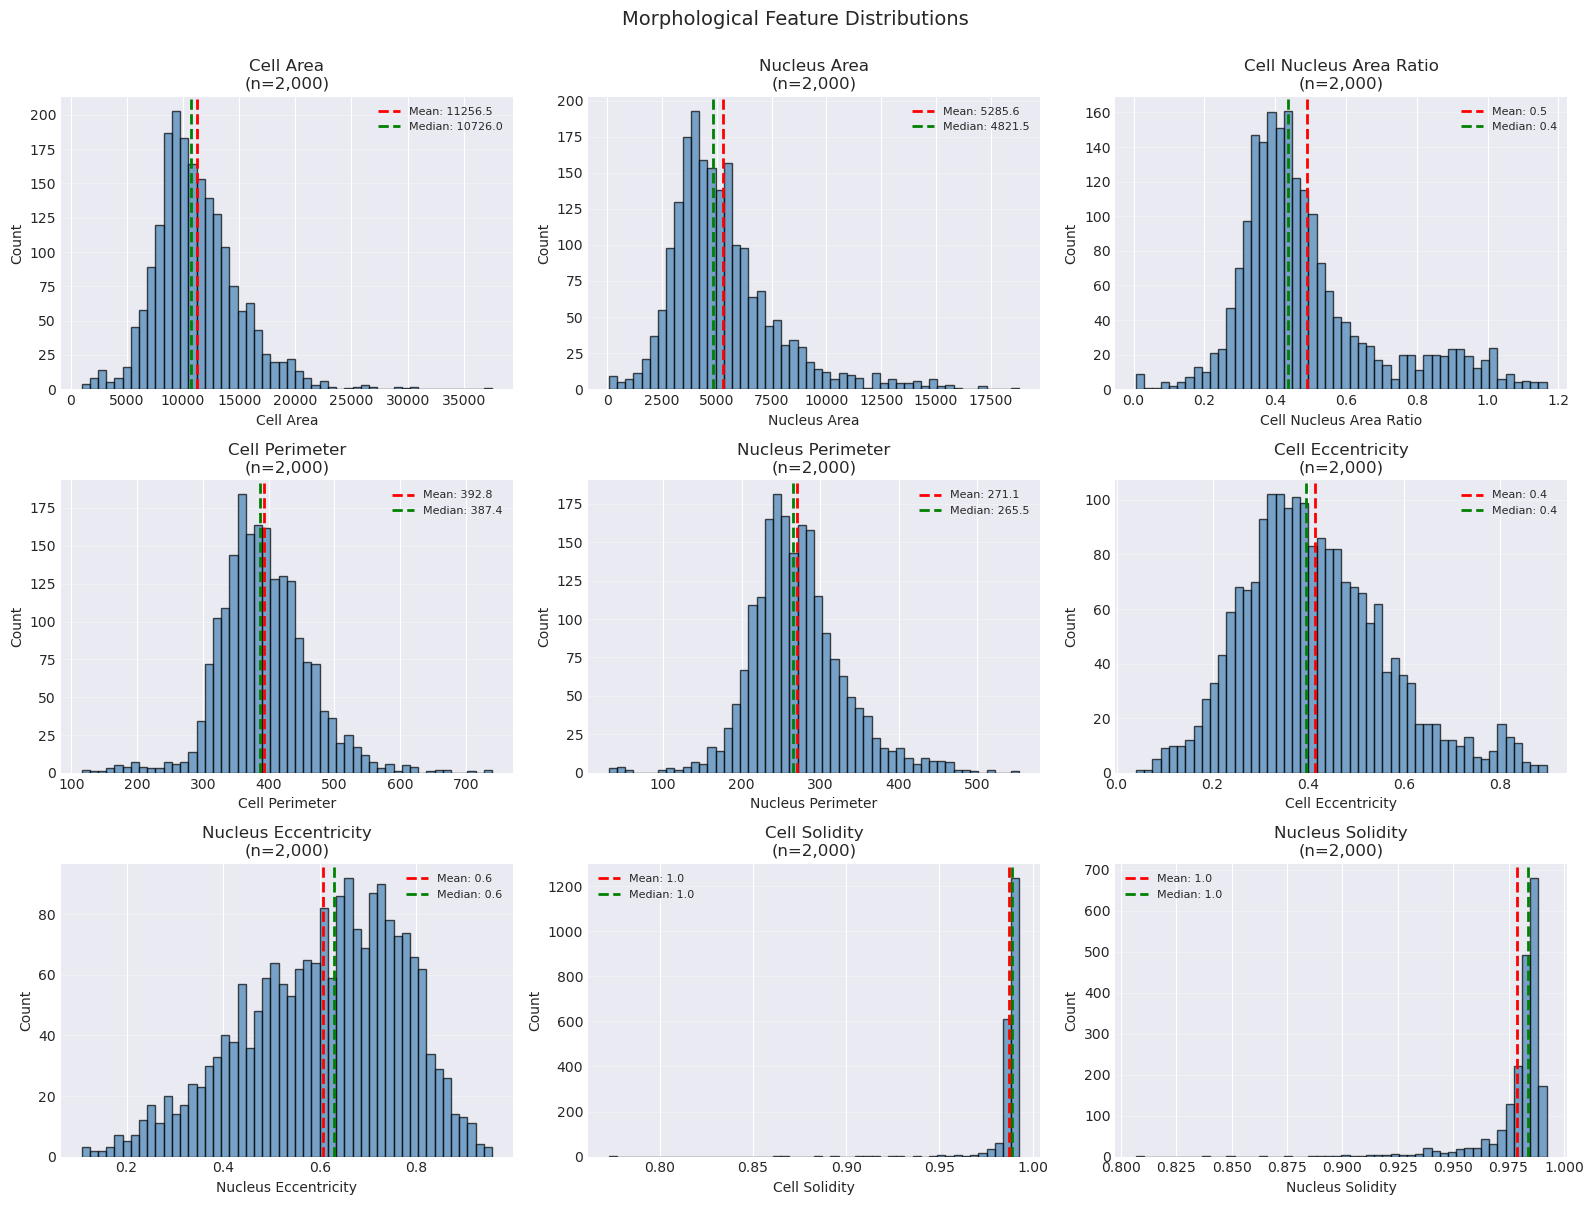


✓ Morphological feature analysis complete!

MORPHOLOGICAL FEATURE SUMMARY

cell_area:
  Mean:   11256.52
  Median: 10726.00
  Std:    3793.48
  Range:  [966.00, 37524.00]

nucleus_area:
  Mean:   5285.60
  Median: 4821.50
  Std:    2429.10
  Range:  [74.00, 18796.00]

cell_nucleus_area_ratio:
  Mean:   0.49
  Median: 0.44
  Std:    0.20
  Range:  [0.01, 1.17]


In [8]:
# Visualize morphological features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

# Select key morphological features to visualize
morph_features = [
    'cell_area', 'nucleus_area', 'cell_nucleus_area_ratio',
    'cell_perimeter', 'nucleus_perimeter',
    'cell_eccentricity', 'nucleus_eccentricity',
    'cell_solidity', 'nucleus_solidity'
]

for idx, feature in enumerate(morph_features):
    ax = axes[idx]
    
    if feature in features_df.columns:
        data = features_df[feature].dropna()
        
        # Plot histogram
        ax.hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Count')
        ax.set_title(f'{feature.replace("_", " ").title()}\n(n={len(data):,})')
        ax.grid(alpha=0.3, axis='y')
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
        ax.legend(fontsize=8)

plt.suptitle('Morphological Feature Distributions', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Morphological feature analysis complete!")

# Print summary statistics for key features
print(f"\n{'='*70}")
print("MORPHOLOGICAL FEATURE SUMMARY")
print(f"{'='*70}")
for feature in ['cell_area', 'nucleus_area', 'cell_nucleus_area_ratio']:
    if feature in features_df.columns:
        data = features_df[feature].dropna()
        print(f"\n{feature}:")
        print(f"  Mean:   {data.mean():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Std:    {data.std():.2f}")
        print(f"  Range:  [{data.min():.2f}, {data.max():.2f}]")

### 6.2 Analyze Channel Intensities

Visualize the relationship between channel intensities and morphological features.

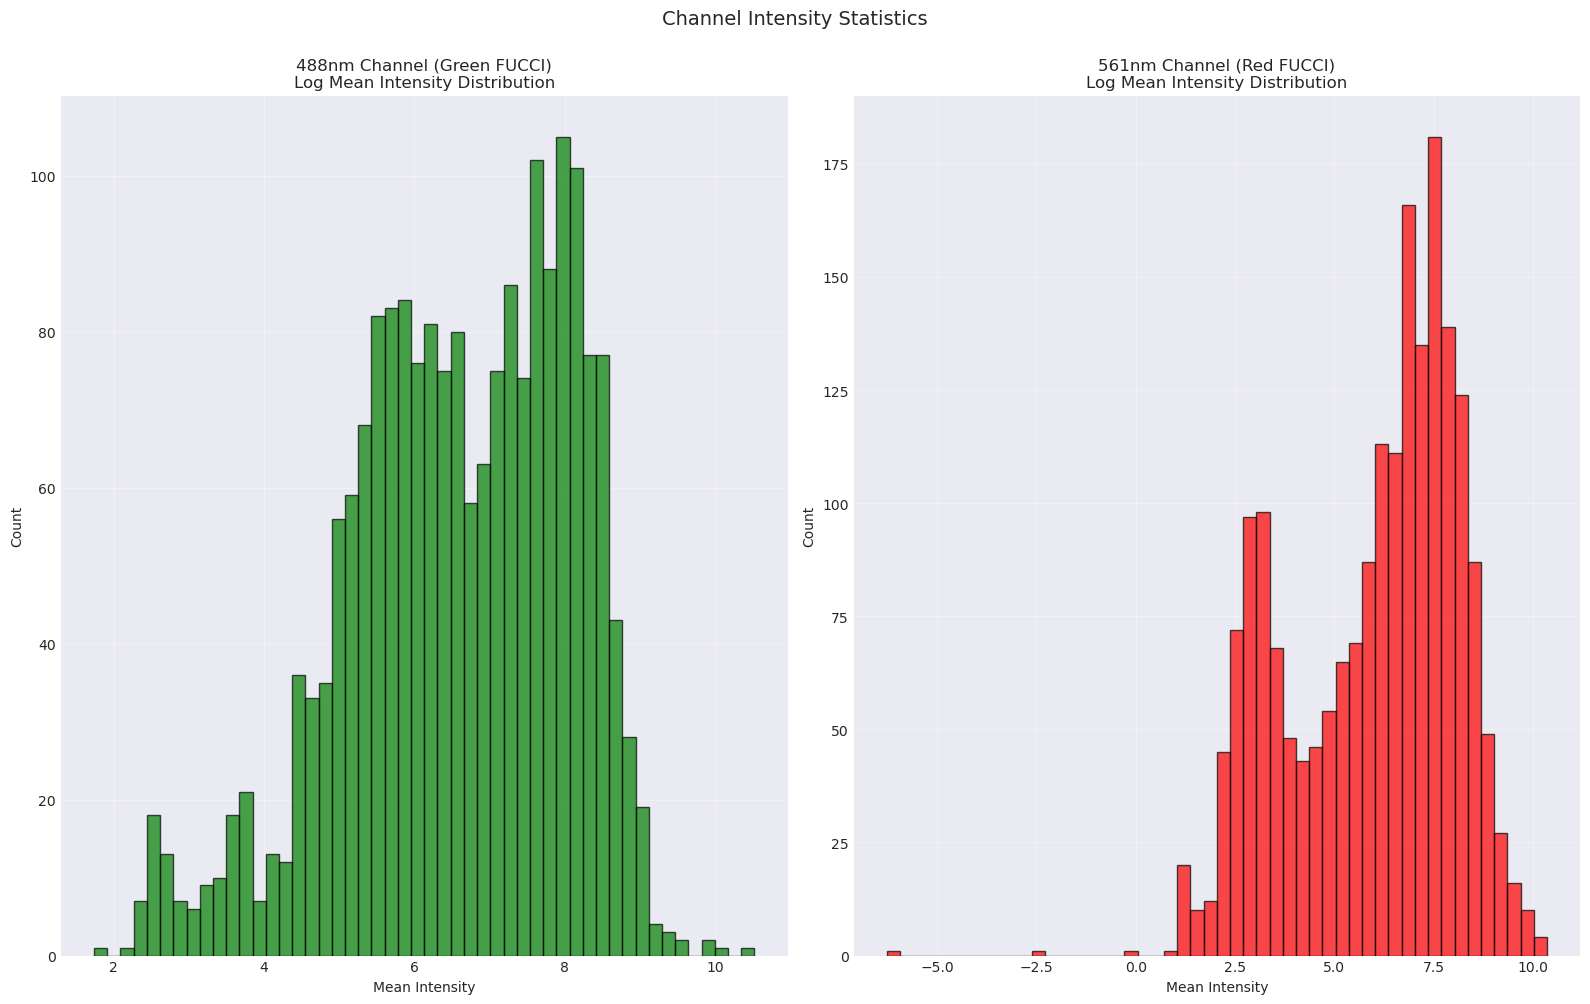


✓ Channel intensity analysis complete!

CHANNEL CORRELATIONS
Correlation between 488 and 561 mean intensities: 0.225


In [12]:
# Analyze channel intensities
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# 488 channel statistics
ax = axes[0]
ax.hist(features_df['fucci_488_log_mean_intensity'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Mean Intensity')
ax.set_ylabel('Count')
ax.set_title('488nm Channel (Green FUCCI)\nLog Mean Intensity Distribution')
ax.grid(alpha=0.3)


# 561 channel statistics
ax = axes[1]
ax.hist(features_df['fucci_561_log_mean_intensity'], bins=50, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Mean Intensity')
ax.set_ylabel('Count')
ax.set_title('561nm Channel (Red FUCCI)\nLog Mean Intensity Distribution')
ax.grid(alpha=0.3)


plt.suptitle('Channel Intensity Statistics', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Channel intensity analysis complete!")

# Print correlation between channels
print(f"\n{'='*70}")
print("CHANNEL CORRELATIONS")
print(f"{'='*70}")
corr_488_561 = features_df['fucci_488_log_mean_intensity'].corr(features_df['fucci_561_log_mean_intensity'])
print(f"Correlation between 488 and 561 mean intensities: {corr_488_561:.3f}")

### 6.3 Correlation Analysis

Explore correlations between morphological features and FUCCI intensities.

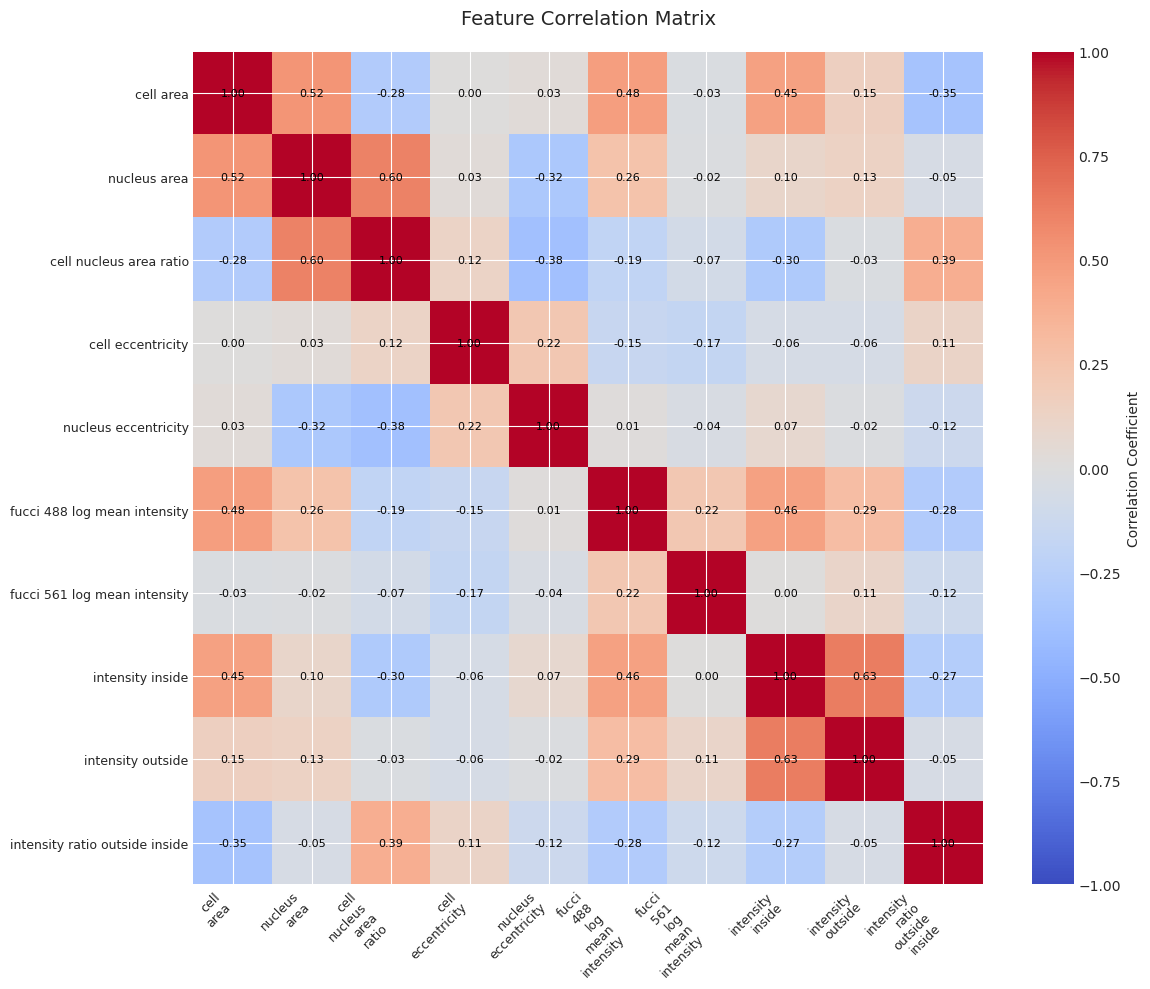


STRONGEST CORRELATIONS (excluding self)

Top 10 strongest correlations:
 1. intensity_inside                         <-> intensity_outside                       : +0.628
 2. nucleus_area                             <-> cell_nucleus_area_ratio                 : +0.603
 3. cell_area                                <-> nucleus_area                            : +0.521
 4. cell_area                                <-> fucci_488_log_mean_intensity            : +0.476
 5. fucci_488_log_mean_intensity             <-> intensity_inside                        : +0.456
 6. cell_area                                <-> intensity_inside                        : +0.454
 7. cell_nucleus_area_ratio                  <-> intensity_ratio_outside_inside          : +0.390
 8. cell_nucleus_area_ratio                  <-> nucleus_eccentricity                    : -0.379
 9. cell_area                                <-> intensity_ratio_outside_inside          : -0.352
10. nucleus_area                             

In [13]:
# Correlation analysis between features
# Select key features for correlation analysis
key_features = [
    'cell_area', 
    'nucleus_area', 
    'cell_nucleus_area_ratio',
    'cell_eccentricity',
    'nucleus_eccentricity',
    'fucci_488_log_mean_intensity',
    'fucci_561_log_mean_intensity',
    'intensity_inside',
    'intensity_outside',
    'intensity_ratio_outside_inside'
]

# Filter to features that exist
available_features = [f for f in key_features if f in features_df.columns]
corr_df = features_df[available_features].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(corr_df, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(available_features)))
ax.set_yticks(range(len(available_features)))
ax.set_xticklabels([f.replace('_', '\n') for f in available_features], rotation=45, ha='right', fontsize=9)
ax.set_yticklabels([f.replace('_', ' ') for f in available_features], fontsize=9)

# Add correlation values
for i in range(len(available_features)):
    for j in range(len(available_features)):
        text = ax.text(j, i, f'{corr_df.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax, label='Correlation Coefficient')
ax.set_title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Find strongest correlations (excluding self-correlations)
print(f"\n{'='*70}")
print("STRONGEST CORRELATIONS (excluding self)")
print(f"{'='*70}")

corr_pairs = []
for i in range(len(available_features)):
    for j in range(i+1, len(available_features)):
        corr_val = corr_df.iloc[i, j]
        corr_pairs.append((available_features[i], available_features[j], corr_val))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nTop 10 strongest correlations:")
for i, (feat1, feat2, corr_val) in enumerate(corr_pairs[:10], 1):
    print(f"{i:2d}. {feat1:40s} <-> {feat2:40s}: {corr_val:+.3f}")

print("\n✓ Correlation analysis complete!")

### 6.4 Cell Cycle Phase Analysis

Analyze the relationship between morphological features and cell cycle phases (inferred from FUCCI intensities).


CELL CYCLE PHASE DISTRIBUTION
G1/S           :   564 cells ( 28.2%)
G0/Early G1    :   564 cells ( 28.2%)
S/G2           :   436 cells ( 21.8%)
G1             :   436 cells ( 21.8%)


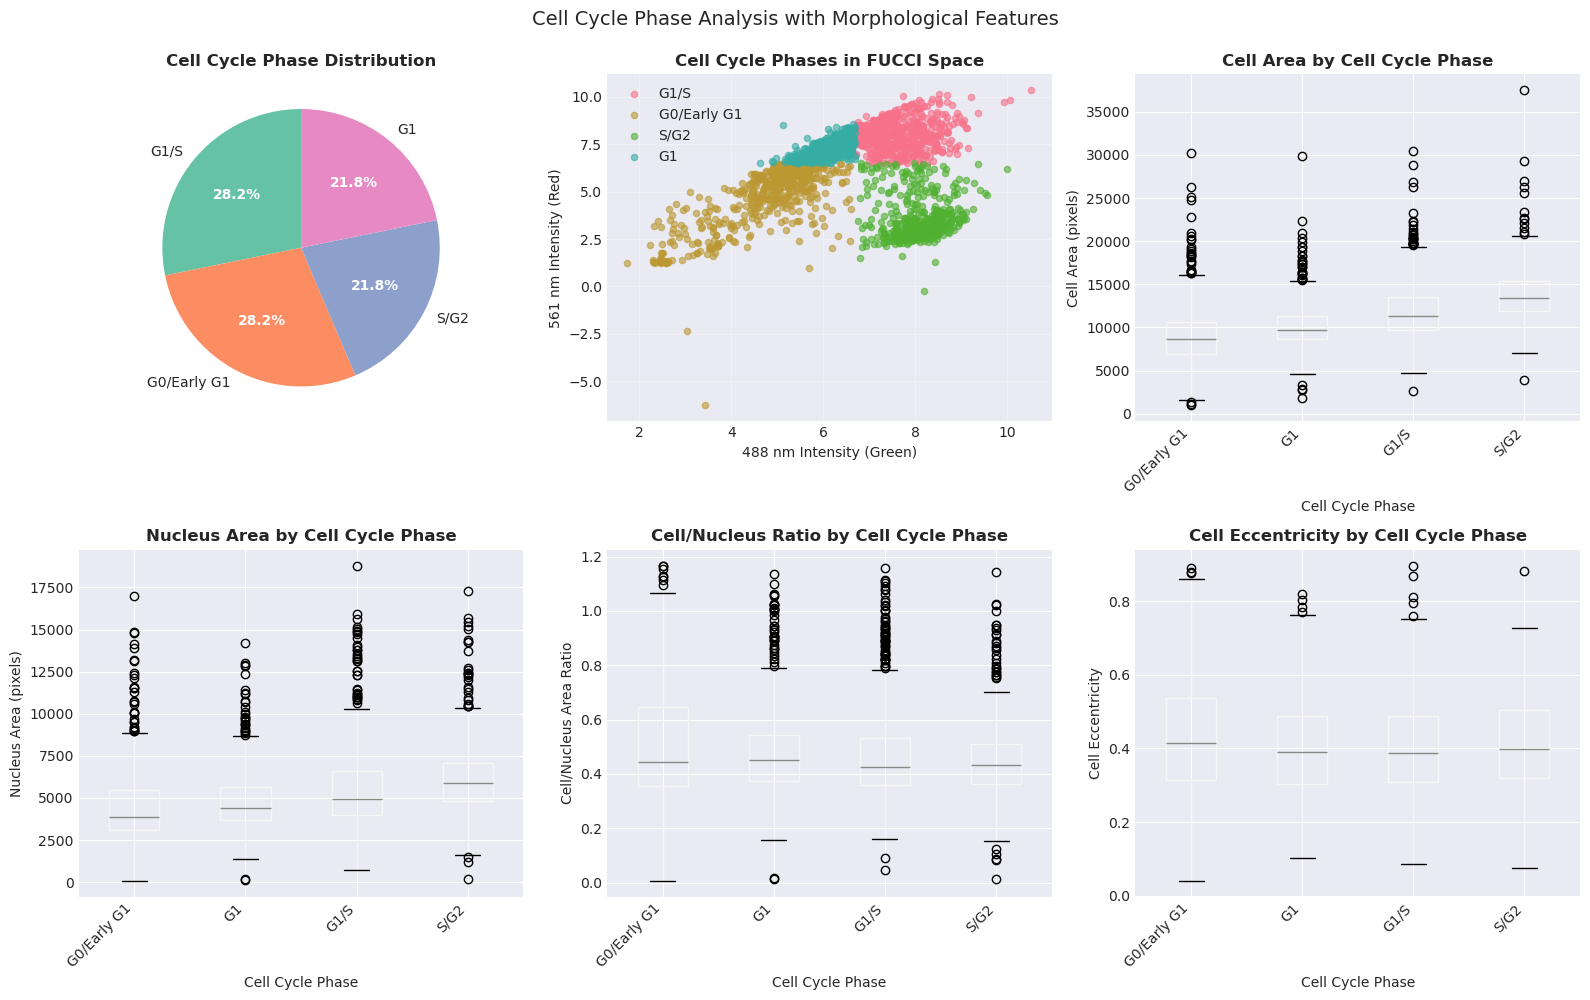


MORPHOLOGICAL FEATURES BY CELL CYCLE PHASE

G0/Early G1 (n=564):
  Cell area:            9152.9 ± 3666.8
  Nucleus area:         4441.8 ± 2301.1
  Cell/nucleus ratio:   0.522 ± 0.245
  Cell eccentricity:    0.440 ± 0.180

G1 (n=436):
  Cell area:            10313.9 ± 2889.5
  Nucleus area:         4938.0 ± 2027.9
  Cell/nucleus ratio:   0.490 ± 0.183
  Cell eccentricity:    0.399 ± 0.140

G1/S (n=564):
  Cell area:            12021.1 ± 3474.7
  Nucleus area:         5652.5 ± 2575.6
  Cell/nucleus ratio:   0.480 ± 0.189
  Cell eccentricity:    0.401 ± 0.133

S/G2 (n=436):
  Cell area:            13931.4 ± 3193.0
  Nucleus area:         6250.1 ± 2326.5
  Cell/nucleus ratio:   0.455 ± 0.152
  Cell eccentricity:    0.412 ± 0.132

✓ Cell cycle phase analysis complete!


In [19]:
# Classify cells into cell cycle phases based on FUCCI intensities
# Simple classification based on median split
median_488 = features_df['fucci_488_log_mean_intensity'].median()
median_561 = features_df['fucci_561_log_mean_intensity'].median()


def classify_phase(row):
    """Classify cell cycle phase based on FUCCI intensities."""
    intensity_488 = row["fucci_488_log_mean_intensity"]
    intensity_561 = row["fucci_561_log_mean_intensity"]

    if intensity_561 > median_561 and intensity_488 < median_488:
        return "G1"  # High red, low green
    elif intensity_488 > median_488 and intensity_561 < median_561:
        return "S/G2"  # High green, low red
    elif intensity_488 > median_488 and intensity_561 > median_561:
        return "G1/S"  # Both high (transition)
    else:
        return "G0/Early G1"  # Both low

features_df["cell_cycle_phase"] = features_df.apply(classify_phase, axis=1)

# Count cells in each phase
phase_counts = features_df['cell_cycle_phase'].value_counts()
print(f"\n{'='*70}")
print("CELL CYCLE PHASE DISTRIBUTION")
print(f"{'='*70}")
for phase, count in phase_counts.items():
    print(f"{phase:15s}: {count:5d} cells ({100*count/len(features_df):5.1f}%)")

# Visualize phase distribution
fig = plt.figure(figsize=(16, 10))

# Phase distribution pie chart
ax1 = plt.subplot(2, 3, 1)
colors = sns.color_palette("Set2", len(phase_counts))
wedges, texts, autotexts = ax1.pie(phase_counts, labels=phase_counts.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')
ax1.set_title('Cell Cycle Phase Distribution', fontsize=12, weight='bold')

# FUCCI scatter with phases colored
ax2 = plt.subplot(2, 3, 2)
for phase in phase_counts.index:
    phase_data = features_df[features_df['cell_cycle_phase'] == phase]
    ax2.scatter(
        phase_data["fucci_488_log_mean_intensity"],
        phase_data["fucci_561_log_mean_intensity"],
        alpha=0.6,
        s=20,
        label=phase,
    )
ax2.set_xlabel('488 nm Intensity (Green)')
ax2.set_ylabel('561 nm Intensity (Red)')
ax2.set_title('Cell Cycle Phases in FUCCI Space', fontsize=12, weight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Cell area by phase
ax3 = plt.subplot(2, 3, 3)
phase_order = ['G0/Early G1', 'G1', 'G1/S', 'S/G2']
phase_order = [p for p in phase_order if p in features_df['cell_cycle_phase'].unique()]
features_df.boxplot(column='cell_area', by='cell_cycle_phase', ax=ax3, 
                    positions=range(len(phase_order)), labels=phase_order)
ax3.set_xlabel('Cell Cycle Phase')
ax3.set_ylabel('Cell Area (pixels)')
ax3.set_title('Cell Area by Cell Cycle Phase', fontsize=12, weight='bold')
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')

# Nucleus area by phase
ax4 = plt.subplot(2, 3, 4)
features_df.boxplot(column='nucleus_area', by='cell_cycle_phase', ax=ax4,
                    positions=range(len(phase_order)), labels=phase_order)
ax4.set_xlabel('Cell Cycle Phase')
ax4.set_ylabel('Nucleus Area (pixels)')
ax4.set_title('Nucleus Area by Cell Cycle Phase', fontsize=12, weight='bold')
plt.sca(ax4)
plt.xticks(rotation=45, ha='right')

# Cell/nucleus ratio by phase
ax5 = plt.subplot(2, 3, 5)
features_df.boxplot(column='cell_nucleus_area_ratio', by='cell_cycle_phase', ax=ax5,
                    positions=range(len(phase_order)), labels=phase_order)
ax5.set_xlabel('Cell Cycle Phase')
ax5.set_ylabel('Cell/Nucleus Area Ratio')
ax5.set_title('Cell/Nucleus Ratio by Cell Cycle Phase', fontsize=12, weight='bold')
plt.sca(ax5)
plt.xticks(rotation=45, ha='right')

# Eccentricity by phase
ax6 = plt.subplot(2, 3, 6)
features_df.boxplot(column='cell_eccentricity', by='cell_cycle_phase', ax=ax6,
                    positions=range(len(phase_order)), labels=phase_order)
ax6.set_xlabel('Cell Cycle Phase')
ax6.set_ylabel('Cell Eccentricity')
ax6.set_title('Cell Eccentricity by Cell Cycle Phase', fontsize=12, weight='bold')
plt.sca(ax6)
plt.xticks(rotation=45, ha='right')

plt.suptitle('Cell Cycle Phase Analysis with Morphological Features', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Print statistics by phase
print(f"\n{'='*70}")
print("MORPHOLOGICAL FEATURES BY CELL CYCLE PHASE")
print(f"{'='*70}")
for phase in phase_order:
    phase_data = features_df[features_df['cell_cycle_phase'] == phase]
    print(f"\n{phase} (n={len(phase_data)}):")
    print(f"  Cell area:            {phase_data['cell_area'].mean():.1f} ± {phase_data['cell_area'].std():.1f}")
    print(f"  Nucleus area:         {phase_data['nucleus_area'].mean():.1f} ± {phase_data['nucleus_area'].std():.1f}")
    print(f"  Cell/nucleus ratio:   {phase_data['cell_nucleus_area_ratio'].mean():.3f} ± {phase_data['cell_nucleus_area_ratio'].std():.3f}")
    print(f"  Cell eccentricity:    {phase_data['cell_eccentricity'].mean():.3f} ± {phase_data['cell_eccentricity'].std():.3f}")

print("\n✓ Cell cycle phase analysis complete!")

## Analyze Low Intensity Cells

Let's examine cells with very low mean intensities in channels 488 (green) or 561 (red). 

In [ ]:
dataset.data_source.load_cell(dataset.cell_ids[0])

In [ ]:
# Compute FUCCI intensities for all cells
import random


print("Computing FUCCI intensities for all cells...")


# Collect intensities for all cells
cell_names = []
intensities_488 = []
intensities_561 = []

for i in tqdm(random.sample(range(len(dataset)), 500)):
    cell_data_raw = dataset.data_source.load_cell(dataset.cell_ids[i])
    target = dataset[i][1]  # Get target intensities

    cell_names.append(dataset.cell_ids[i])
    intensities_488.append(target[0])
    intensities_561.append(target[1])

intensities_488 = np.array(intensities_488)
intensities_561 = np.array(intensities_561)

print(f"Computed intensities for {len(cell_names)} cells")

# Print statistics
print(f"\nIntensity Statistics:")
print(f"{'='*60}")
print(f"Channel 488 (Green):")
print(f"  Range: [{intensities_488.min():.2f}, {intensities_488.max():.2f}]")
print(f"  Mean: {intensities_488.mean():.2f} ± {intensities_488.std():.2f}")
print(f"  Median: {np.median(intensities_488):.2f}")
print(f"  10th percentile: {np.percentile(intensities_488, 10):.2f}")

print(f"\nChannel 561 (Red):")
print(f"  Range: [{intensities_561.min():.2f}, {intensities_561.max():.2f}]")
print(f"  Mean: {intensities_561.mean():.2f} ± {intensities_561.std():.2f}")
print(f"  Median: {np.median(intensities_561):.2f}")
print(f"  10th percentile: {np.percentile(intensities_561, 10):.2f}")
print(f"{'='*60}")

In [ ]:
# Create histogram of FUCCI intensities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Channel 488 histogram
ax = axes[0]
ax.hist(intensities_488, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(np.percentile(intensities_488, 10), color='red', 
           linestyle='--', linewidth=2, label='10th percentile')
ax.axvline(np.mean(intensities_488), color='blue',
           linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Intensity (a.u.)', fontsize=12)
ax.set_ylabel('Number of Cells', fontsize=12)
ax.set_title('Channel 488 (Green) Intensity Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Channel 561 histogram
ax = axes[1]
ax.hist(intensities_561, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.axvline(np.percentile(intensities_561, 10), color='darkred',
           linestyle='--', linewidth=2, label='10th percentile')
ax.axvline(np.mean(intensities_561), color='blue',
           linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Intensity (a.u.)', fontsize=12)
ax.set_ylabel('Number of Cells', fontsize=12)
ax.set_title('Channel 561 (Red) Intensity Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Find cells with low intensities (bottom 10th percentile)
percentile = 10
threshold_488 = np.percentile(intensities_488, percentile)
threshold_561 = np.percentile(intensities_561, percentile)

# Find indices of low intensity cells
low_488_mask = intensities_488 < threshold_488
low_561_mask = intensities_561 < threshold_561

low_488_indices = np.where(low_488_mask)[0]
low_561_indices = np.where(low_561_mask)[0]

# Sort by intensity (lowest first)
low_488_indices = low_488_indices[np.argsort(intensities_488[low_488_indices])]
low_561_indices = low_561_indices[np.argsort(intensities_561[low_561_indices])]

print(f"Found {len(low_488_indices)} cells with low 488 intensity (< {threshold_488:.2f})")
print(f"Found {len(low_561_indices)} cells with low 561 intensity (< {threshold_561:.2f})")

# Get cell IDs for lowest intensity cells
n_examples = 20
low_488_cells = [cell_names[i] for i in low_488_indices[:n_examples]]
low_561_cells = [cell_names[i] for i in low_561_indices[:n_examples]]

print(f"\nLowest 488 intensity cells:")
for i, cell_id in enumerate(low_488_cells):
    idx = low_488_indices[i]
    print(f"  {i+1}. {cell_id}: 488={intensities_488[idx]:.2f}, 561={intensities_561[idx]:.2f}")

print(f"\nLowest 561 intensity cells:")
for i, cell_id in enumerate(low_561_cells):
    idx = low_561_indices[i]
    print(f"  {i+1}. {cell_id}: 488={intensities_488[idx]:.2f}, 561={intensities_561[idx]:.2f}")

In [ ]:
# Visualize cells with low 488 intensity
fig, axes = plt.subplots(n_examples, 4, figsize=(16, n_examples * 3))
fig.suptitle(f'Cells with Low Channel 488 (Green) Intensity (< {threshold_488:.2f})', 
             fontsize=16, fontweight='bold')

for i, cell_id in enumerate(low_488_cells):
    # Get cell data
    cell_data_raw = dataset.data_source.load_cell(cell_id)

    idx = low_488_indices[i]
    int_488 = intensities_488[idx]
    int_561 = intensities_561[idx]

    # Get middle plane for each channel
    channels = ['bf', '405', '488', '561']
    for j, ch in enumerate(channels):
        ax = axes[i, j] if n_examples > 1 else axes[j]

        if ch in cell_data_raw.channels:
            # Get middle plane
            planes = cell_data_raw.channels[ch]
            mid_idx = len(planes) // 2
            img = planes[mid_idx]

            # Adjust contrast
            vmin, vmax = np.percentile(img, [1, 99])

            # Choose colormap
            if ch == 'bf':
                cmap = 'gray'
            elif ch == '488':
                cmap = 'Greens'
            elif ch == '561':
                cmap = 'Reds'
            else:
                cmap = 'Blues'

            if ch in ['488', '561']:
                img = np.clip(img - img[cell_data_raw.segmentation[mid_idx] == 0].mean(), 0, None)
            ax.imshow(img, cmap='gray')

            if cell_data_raw.segmentation:
                seg_planes = cell_data_raw.segmentation

                seg_mask = seg_planes[mid_idx]
                if seg_mask is not None and np.any(seg_mask):
                    ax.contour(seg_mask, levels=[0.5], colors='yellow', linewidths=1)

            if cell_data_raw.nuclei_segmentation:
                nuclei_planes = cell_data_raw.nuclei_segmentation
                if len(nuclei_planes) > mid_idx:
                    nuc_mask = nuclei_planes[mid_idx]
                    if nuc_mask is not None and np.any(nuc_mask):
                        ax.contour(nuc_mask, levels=[0.5], colors='cyan', linewidths=1, linestyles='--')
            ax.set_title(f'{ch}', fontsize=10)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
            ax.set_title(ch, fontsize=10)

        ax.axis('off')

        # Add cell info on first column
        if j == 0:
            ax.text(-0.5, 0.5, f'{cell_id}\n488: {int_488:.1f}\n561: {int_561:.1f}',
                   transform=ax.transAxes, ha='right', va='center',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize cells with low 561 intensity
fig, axes = plt.subplots(n_examples, 4, figsize=(16, n_examples * 3))
fig.suptitle(f'Cells with Low Channel 561 (Red) Intensity (< {threshold_561:.2f})', 
             fontsize=16, fontweight='bold')

for i, cell_id in enumerate(low_561_cells):
    # Get cell data
    cell_data_raw = dataset.data_source.load_cell(cell_id)

    idx = low_561_indices[i]
    int_488 = intensities_488[idx]
    int_561 = intensities_561[idx]

    # Get middle plane for each channel
    channels = ['bf', '405', '488', '561']
    for j, ch in enumerate(channels):
        ax = axes[i, j] if n_examples > 1 else axes[j]

        if ch in cell_data_raw.channels:
            # Get middle plane
            planes = cell_data_raw.channels[ch]
            mid_idx = len(planes) // 2
            img = planes[mid_idx]

            # Adjust contrast
            vmin, vmax = np.percentile(img, [1, 99])

            # Choose colormap
            if ch == 'bf':
                cmap = 'gray'
            elif ch == '488':
                cmap = 'Greens'
            elif ch == '561':
                cmap = 'Reds'
            else:
                cmap = 'Blues'

            if ch in ["488", "561"]:
                img = np.clip(
                    img - img[cell_data_raw.segmentation[mid_idx] == 0].mean(), 0, None
                )
            ax.imshow(img, cmap='gray')
            if cell_data_raw.segmentation:
                seg_planes = cell_data_raw.segmentation

                seg_mask = seg_planes[mid_idx]
                if seg_mask is not None and np.any(seg_mask):
                    ax.contour(seg_mask, levels=[0.5], colors="yellow", linewidths=1)

            if cell_data_raw.nuclei_segmentation:
                nuclei_planes = cell_data_raw.nuclei_segmentation
                if len(nuclei_planes) > mid_idx:
                    nuc_mask = nuclei_planes[mid_idx]
                    if nuc_mask is not None and np.any(nuc_mask):
                        ax.contour(
                            nuc_mask,
                            levels=[0.5],
                            colors="cyan",
                            linewidths=1,
                            linestyles="--",
                        )
            ax.set_title(f'{ch}', fontsize=10)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
            ax.set_title(ch, fontsize=10)

        ax.axis('off')

        # Add cell info on first column
        if j == 0:
            ax.text(-0.5, 0.5, f'{cell_id}\n488: {int_488:.1f}\n561: {int_561:.1f}',
                   transform=ax.transAxes, ha='right', va='center',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()